In [1]:
import numpy as np
import pandas as pd
import random
from scipy.spatial import distance
from scipy import linalg
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
def hard_k_means_cluster(k, data, N, thresh):
    """Function to impliment k-means clustering with k clusters on a 2d numpy array of data, formatted such that 
    each row is a single c-dimensional data point, where c is the number of columns"""
    num_rows = data.shape[0]
    num_cols = data.shape[1]
    
    best_total_sqr_dist = -1
    best_cluster_centroids = -1
    best_cluster_labels = -1
    
    min_max_list = []
    cluster_trial_sqr_dist_list = []
    
    # Get the min and max of data dimension
    for c in range(num_cols):
        min_max_list.append((data[:,c].min(), data[:,c].max()))
    
    cluster_trial = 0
    while cluster_trial < N:
        # Initiate random centroids
        centroids = np.ones((k, num_cols))
        old_centroids = np.ones((k, num_cols))
        cluster_labels = -1

        # Create k random centroids with dimension values within the range of each data dimension
        for r in range(k):
            for c in range(num_cols):
                centroids[r,c] = random.uniform(min_max_list[c][0],min_max_list[c][1])   
                    
        # Create a list to keep track of the distances
        best_iteration_dist = -1
        for iteration in range(20):
            
            ### Update the clusters###

            # Initiate an array where each index holds the new cluster identity of the data at the correspoinding row
            # index
            new_labels = np.ones(num_rows, dtype=int)
            
            # Iterate over each row of the data
            for r in range(num_rows):
                
                # Get the identity closest centroid to data vector r
                centroid_dists = [distance.euclidean(i,data[r,:]) for i in centroids]
                closest_centroid = np.argmin(centroid_dists)

                # Add the centroid indentity to the array new_clusters
                new_labels[r] = closest_centroid

            ### Update the centroid values###
            iteration_dist = 0
            old_centroids = centroids.copy()
            
            for label in np.unique(new_labels):
                # get all the points belonging to that cluster
                cluster_data_idx = (new_labels == label)
                cluster_data = data[cluster_data_idx,:]
                
                # set the centroid equal to the mean of that cluster
                if len(cluster_data) != 0:
                    centroids[label,:] = np.mean(cluster_data, axis=0)
                    
                else: centroids[label,:] = data[np.random.choice(num_rows,size=1), :] 
                    
            cluster_labels = new_labels
            
            # Check for centroid convergence
            diff = ((centroids - old_centroids) ** 2).mean()
            if diff <= thresh and iteration != 0: 
                break
                
        
        # If a cluster has no labels, do not update
        if len(np.unique(cluster_labels)) == k:
            total_sqr_dist = 0

            for centroid_idx, centroid in enumerate(centroids):
                for r_idx in range(num_rows):
                    if cluster_labels[r_idx] == centroid_idx:
                        total_sqr_dist += distance.euclidean(data[r_idx,:], centroid)**2

            cluster_trial_sqr_dist_list.append(total_sqr_dist)
            
            # Check to see if this run had a lower total squared distance and update the best values if it did            
            if (cluster_trial_sqr_dist_list[-1] < best_total_sqr_dist) or (best_total_sqr_dist == -1):
                best_total_sqr_dist = cluster_trial_sqr_dist_list[-1]
                best_cluster_centroids = centroids
                best_cluster_labels = cluster_labels
            
#             print("Clustering successful")
            cluster_trial +=1

        else: 
#             print("Empty cluster, trying again")
            continue

    return best_cluster_centroids, best_cluster_labels, best_total_sqr_dist, cluster_trial_sqr_dist_list


In [3]:
# This is giving me a very low total squared distance...
data = pd.read_csv("w10-data.tbl", delim_whitespace=True)
log_data_arr = np.log(data.values)
centroids, cluster_labels, sqr_dist, sqr_dist_list = hard_k_means_cluster(8, log_data_arr, 10, 10**(-6))

In [4]:
def PCA(data_arr, n):
    """Takes in a non-standardized data array and performs PCA using SVD method. Data should be in tidy format,
    with rows as observations and columns as variables"""
    num_rows = data_arr.shape[0]
    # Center the data
    centroid = np.mean(data_arr, axis=0)
    X_star = data_arr-centroid
    
    # Do SVD
    U, s, V_T = linalg.svd(X_star)
    eig_vectors = np.transpose(V_T)
    eig_vals = np.divide(s**2, num_rows-1)
    
    # Get the data projected into the number of PCA components specified
    PCA_data = np.matmul(X_star, eig_vectors[:,0:(n+1)])
    
    return PCA_data, eig_vectors, eig_vals, s, U, centroid

def PCA_plots(PCA_data, eig_vectors, eig_vals, labels, control_eig_vals):
    """Creates a biplot for the PCA data in 2d, plus a scree plot of the varaition captured by each principle
    component"""
    #TODO add lables for both plots
    
    ### Plot the biplot ###
    PC1 = PCA_data[:,0]
    PC2 = PCA_data[:,1]
    num_dims = PCA_data.shape[0]
    
    x_scale = np.true_divide(1,(max(PC1) - min(PC1)))
    y_scale = np.true_divide(1,(max(PC2) - min(PC2)))
    eig_vectors_weight = [np.linalg.norm(eig_vectors[i,0:2]) for i in range(num_dims)]
    eig_vectors_weight = np.true_divide(eig_vectors_weight, sum(eig_vectors_weight))
    
    plt.figure(1, figsize=(10,10))
    plt.scatter(PC1*x_scale, PC2*y_scale)
    
    for i in range(num_dims):
        plt.arrow(0, 0, eig_vectors[i,0], eig_vectors[i,1])
        if labels != None:
            if eig_vectors_weight[i] > 0.05:
                plt.text(eig_vectors[i,0]* 1.15, eig_vectors[i,1] * 1.15, labels[i], color = 'r',
                         ha = 'center', va = 'center')
    plt.title("Biplot for first 2 PCs")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
            
    ### Plot the scree plot ###         
    plt.figure(2, figsize=(10,10))
    plt.plot(eig_vals)
    plt.plot(control_eig_vals)
    plt.title("Scree plot for Watson and negative control data eigenvalues")
    plt.xlabel("# PCs")
    plt.ylabel("Eigenvalue")
    plt.legend(["Watson's data", "Negative control data"])

    
def plot_clusters(data, cluster_labels, centroids):
    #TODO add labels for plots
    
    plt.figure(figsize=(10,10))
    clusters = np.unique(cluster_labels)
    
    for cluster in clusters:
        plot_data_idx = (cluster_labels == cluster)
        plot_data = data[plot_data_idx,:]
        plt.scatter(plot_data[:,0], plot_data[:,1], marker='o', alpha=0.8)
    
    plt.scatter(centroids[:,0], centroids[:,1], marker='*', c='k')
    
    plt.title("K-means clustering of data")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    
    return None

199


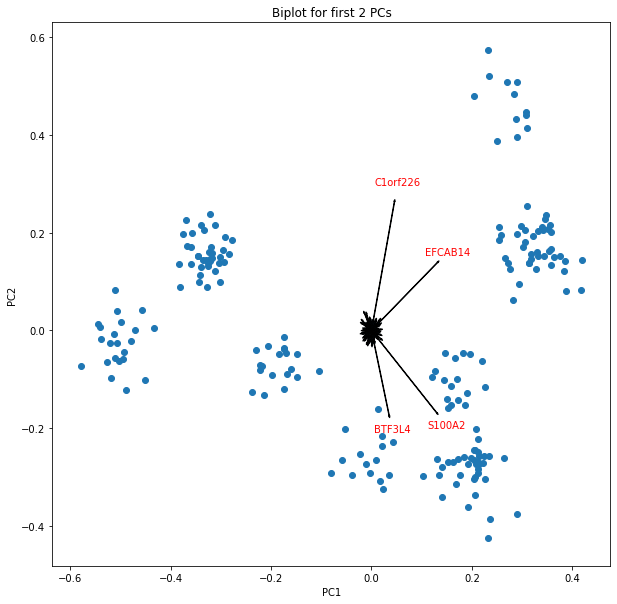

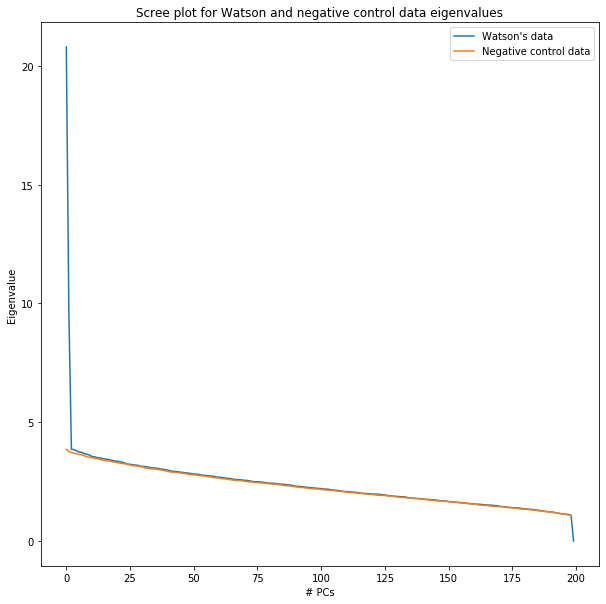

In [5]:
labels_list = list(data.head())
neg_control_data = pd.read_csv("w10-eigen.tbl", header=None, index_col=0, delim_whitespace=True)
PCA_data, eig_vectors, eig_vals, s, U, star_centroid = PCA(log_data_arr, 8) 
PCA_plots(PCA_data, eig_vectors, eig_vals, labels_list, neg_control_data.values)
print(len(neg_control_data))

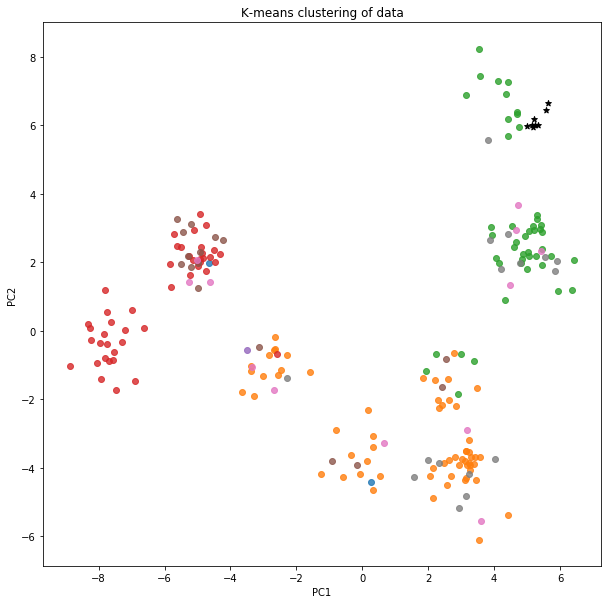

In [6]:
plot_clusters(PCA_data, cluster_labels, centroids)

In [7]:
pca_centroids, pca_cluster_labels, pca_sqr_dist, test = hard_k_means_cluster(8, 
                                                                      np.asarray(PCA_data[:,0:2]), 15, 10**(-6))

In [8]:
print(test)
print(pca_sqr_dist)

[219.41739506987366, 201.46033461155085, 294.9255427732416, 300.7140060938403, 130.56501825299577, 211.34718911940996, 294.9478645092877, 300.18297702368176, 293.6804405593133, 310.6909350644274, 303.1208657411576, 222.00909962921784, 310.69093506442726, 209.7409401595729, 130.56501825299577]
130.56501825299577


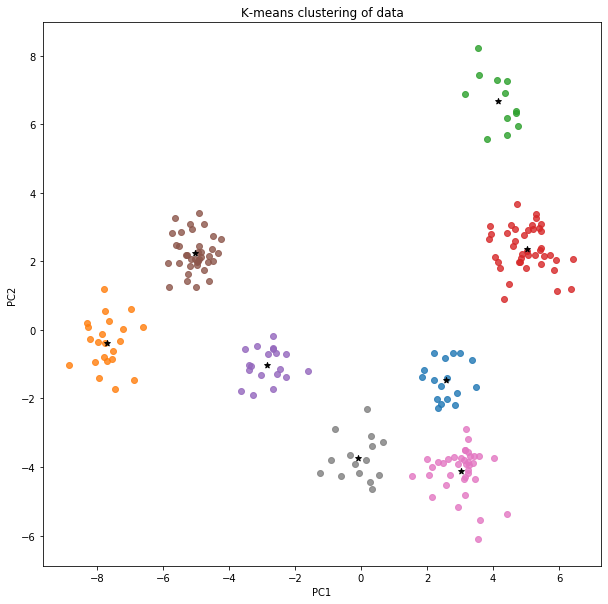

In [9]:
plot_clusters(PCA_data[:,0:2], pca_cluster_labels, pca_centroids)

In [26]:
def reconstruct_pca_data(X_star, centroid, V, s, U, q):
    S_mat = np.diag(s[0:q])
    V_T = np.transpose(V[:,0:q])
#     Y = np.matmul(U[:,0:q],S_mat)
    a = np.matmul(U[:,0:q],S_mat)
    X_star_q = np.matmul(a, V_T)
    X_q = X_star_q + centroid[np.newaxis,:]
    
    return X_q

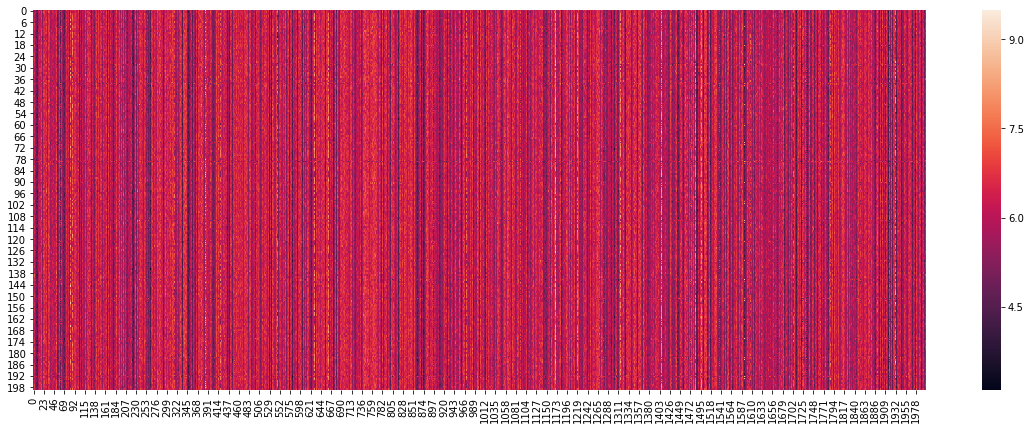

In [27]:
test = reconstruct_pca_data(PCA_data, star_centroid, eig_vectors, s, U, 47)
plt.figure(figsize=(20,7))
sns.heatmap(test)

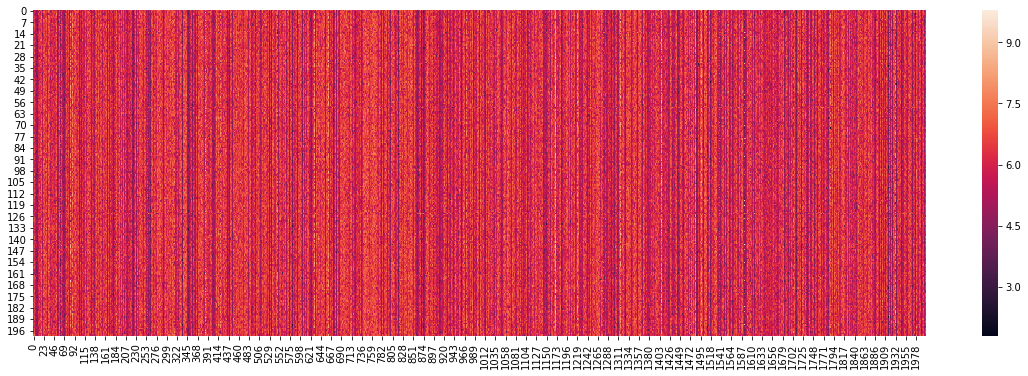

In [12]:
plt.figure(figsize=(20,6))
sns.heatmap(log_data_arr)